In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import os
import cv2

In [2]:
labels = ["NORMAL", "PNEUMONIA"]
batch_size = 32
torch.manual_seed(1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ImageDataset(Dataset):
  def __init__(self, data, label, transform):
    self.data = data
    self.label = label
    self.transform = transform

  def __getitem__(self, index):
    return self.transform(self.data[index]), self.label[index]

  def __len__(self):
    return len(self.label)

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation((0, 30))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150))
])

In [6]:
def get_train_data(data_dir):
  data = []
  labels_data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        image = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        res = cv2.resize(image, (150, 150))
        data.append(res)
        met = [0, 0]
        met[class_num] = 1
        labels_data.append(met)
      except Exception as e:
        print(e)
  return np.array(data), np.array(labels_data)

In [7]:
train_data, train_labels = get_train_data("/content/drive/MyDrive/data/train")
test_data, test_labels = get_train_data("/content/drive/MyDrive/data/test")
val_data, val_labels = get_train_data("/content/drive/MyDrive/data/val")

<Axes: xlabel='count'>

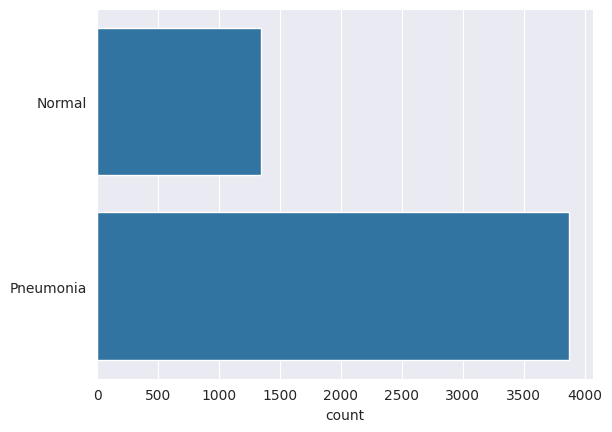

In [8]:
l = []
for f in train_labels:
  if f[1] == 1:
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)

In [9]:
train_data_full = np.concatenate([train_data, val_data])
train_labels_full = np.concatenate([train_labels, val_labels])

In [10]:
ext_data = []
ext_labels = []
for d, l in zip(train_data_full, train_labels_full):
  if l[0] == 1:
    ext_data.append(d)
    ext_labels.append(l)
ext_data = np.array(ext_data)
ext_labels = np.array(ext_labels)

In [11]:
train_data_ext = np.concatenate([train_data_full, ext_data])
train_labels_ext = np.concatenate([train_labels_full, ext_labels])

<Axes: xlabel='count'>

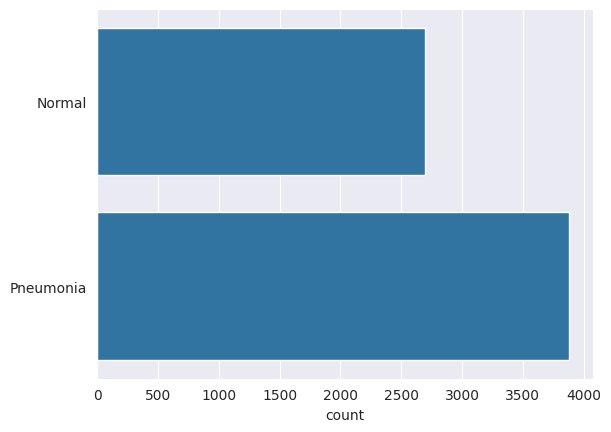

In [12]:
l = []
for f in train_labels_ext:
  if f[1] == 1:
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)

In [13]:
train_data_new, val_data_new, train_labels_new, val_labels_new = train_test_split(train_data_ext, train_labels_ext, test_size=0.2)

In [14]:
print(len(train_labels_new))
print(len(val_labels_new))

5264
1317


In [15]:
train_dataset = ImageDataset(train_data_new, train_labels_new, transform_train)
test_dataset = ImageDataset(test_data, test_labels, transform_test)
val_dataset = ImageDataset(val_data_new, val_labels_new, transform_test)

<Axes: xlabel='count'>

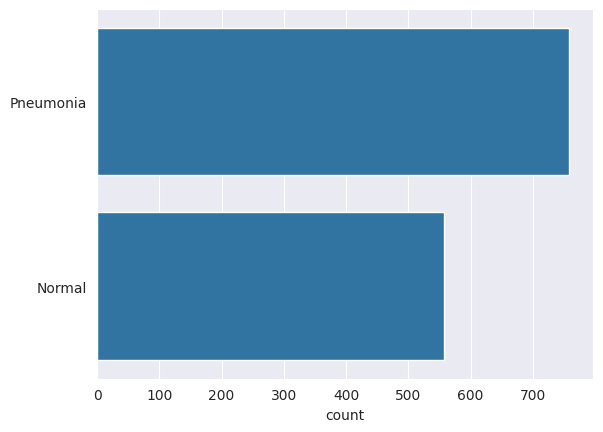

In [16]:
l = []
for i in val_labels_new:
  if i[1] == 1:
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)

In [17]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size, shuffle=False)

In [150]:
model = nn.Sequential()
model.add_module("conv_1", nn.Conv2d(1, 32, 5, 1, 1))
model.add_module("relu_1", nn.LeakyReLU())
model.add_module("bn_1", nn.BatchNorm2d(32))
model.add_module("pool_1", nn.MaxPool2d(2, 2))

model.add_module("conv_2", nn.Conv2d(32, 64, 5, 1, 1))
model.add_module("relu_2", nn.LeakyReLU())
model.add_module("drop_2", nn.Dropout(0.1))
model.add_module("bn_2", nn.BatchNorm2d(64))
model.add_module("pool_2", nn.MaxPool2d(2, 2))

model.add_module("conv_3", nn.Conv2d(64, 64, 5, 1, 1))
model.add_module("relu_3", nn.LeakyReLU())
model.add_module("drop_3", nn.Dropout(0.1))
model.add_module("bn_3", nn.BatchNorm2d(64))
model.add_module("pool_3", nn.MaxPool2d(2, 2))

model.add_module("conv_4", nn.Conv2d(64, 128, 3, 1, 1))
model.add_module("relu_4", nn.LeakyReLU())
model.add_module("drop_4", nn.Dropout(0.2))
model.add_module("bn_4", nn.BatchNorm2d(128))
model.add_module("pool_4", nn.MaxPool2d(2, 2))

model.add_module("conv_5", nn.Conv2d(128, 256, 3, 1, 1))
model.add_module("relu_5", nn.LeakyReLU())
model.add_module("drop_5", nn.Dropout(0.2))
model.add_module("bn_5", nn.BatchNorm2d(256))
model.add_module("pool_5", nn.MaxPool2d(2, 2))

model.add_module("flatten", nn.Flatten())

model.add_module("fc_1", nn.Linear(4096, 128))
model.add_module("relu_6", nn.LeakyReLU())
model.add_module("drop", nn.Dropout(0.2))
model.add_module("fc_2", nn.Linear(128, 2))

In [151]:
model.to(device)
model.forward(torch.ones((1, 1, 150, 150)).to(device)).shape

torch.Size([1, 2])

In [152]:
sum([p.numel() for p in model.parameters()])

1049346

In [153]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)

In [154]:
def train_model(model, train_dl, test_dl_den, epochs):
  loss_hist_train = [0] * epochs
  accuracy_hist_train = [0] * epochs
  loss_hist_val = [0] * epochs
  accuracy_hist_val = [0] * epochs
  min_loss = 10**9
  model.train()
  for epoch in range(epochs):
    for x, y in train_dl:
      x = x.float().to(device)
      y = y.float().to(device)
      pred = model.forward(x)
      param_conv_1 = torch.cat([x.view(-1) for x in model.conv_1.parameters()])
      param_conv_2 = torch.cat([x.view(-1) for x in model.conv_2.parameters()])
      param_conv_3 = torch.cat([x.view(-1) for x in model.conv_3.parameters()])
      param_conv_4 = torch.cat([x.view(-1) for x in model.conv_4.parameters()])
      param_conv_5 = torch.cat([x.view(-1) for x in model.conv_5.parameters()])
      param_fc_1 = torch.cat([x.view(-1) for x in model.fc_1.parameters()])
      param_fc_2 = torch.cat([x.view(-1) for x in model.fc_2.parameters()])
      params = torch.cat([param_conv_1, param_conv_2, param_conv_3, param_conv_4, param_conv_5])
      l1 = 0.0001 * torch.norm(params, 1) + 0.00001 * torch.norm(torch.cat([param_fc_1, param_fc_2]))
      l2 = 0.001 * torch.norm(torch.cat([param_fc_1, param_fc_2]), 2) + 0.00001 * torch.norm(torch.cat([params]), 2)
      loss = criterion.forward(pred, y)
      loss.backward()
      opt.step()
      opt.zero_grad()
      loss_hist_train[epoch] += loss.item() * y.size(0)
      is_correct = (torch.argmax(pred, 1) == torch.argmax(y, 1)).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    accuracy_hist_train[epoch] = accuracy_hist_train[epoch].cpu()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x, y in test_dl_den:
        x = x.float().to(device)
        y = y.float().to(device)
        pred = model.forward(x)
        loss = criterion.forward(pred, y)
        loss_hist_val[epoch] += loss.item() * y.size(0)
        is_correct = (torch.argmax(pred, 1) == torch.argmax(y, 1)).float()
        accuracy_hist_val[epoch] += is_correct.sum()
    accuracy_hist_val[epoch] = accuracy_hist_val[epoch].cpu()
    loss_hist_val[epoch] /= len(test_dl_den.dataset)
    accuracy_hist_val[epoch] /= len(test_dl_den.dataset)
    if loss_hist_val[epoch] < min_loss:
      min_loss = loss_hist_val[epoch]
      torch.save(model, "/content/drive/MyDrive/r/SysitnCNNTorch02.pth")
    print("-" * 50)
    print(f"Точность эпохи {epoch+1}: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_val[epoch]:.4f}")
    print(f"Потери эпохи {epoch+1}: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_val[epoch]:.4f}")
  return loss_hist_train, loss_hist_val, accuracy_hist_train, accuracy_hist_val

In [155]:
hist = train_model(model, train_dl, val_dl, 5)

--------------------------------------------------
Точность эпохи 1: 0.9145 val_accuracy: 0.8276
Потери эпохи 1: 0.2125 val_loss: 0.3603
--------------------------------------------------
Точность эпохи 2: 0.9523 val_accuracy: 0.9711
Потери эпохи 2: 0.1227 val_loss: 0.1001
--------------------------------------------------
Точность эпохи 3: 0.9660 val_accuracy: 0.9643
Потери эпохи 3: 0.0921 val_loss: 0.0865
--------------------------------------------------
Точность эпохи 4: 0.9643 val_accuracy: 0.9719
Потери эпохи 4: 0.0938 val_loss: 0.0725
--------------------------------------------------
Точность эпохи 5: 0.9715 val_accuracy: 0.9567
Потери эпохи 5: 0.0763 val_loss: 0.1122


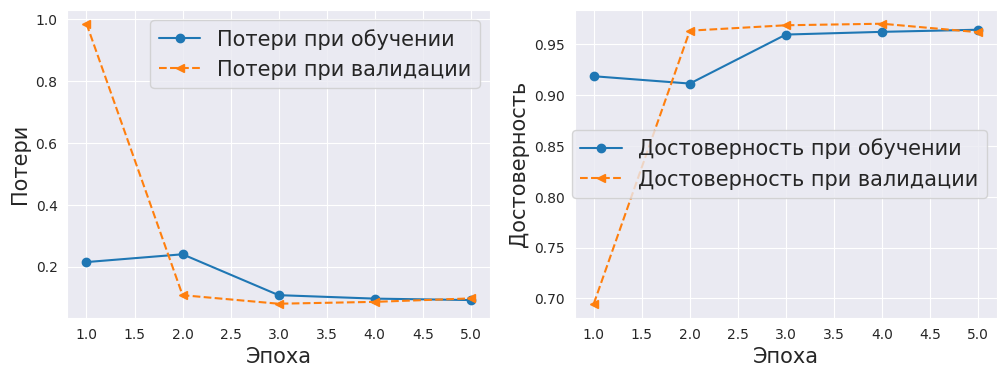

In [102]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax =  fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Потери при обучении")
ax.plot(x_arr, hist[1], "--<", label="Потери при валидации")
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха", size=15)
ax.set_ylabel("Потери", size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Достоверность при обучении")
ax.plot(x_arr, hist[3], "--<", label="Достоверность при валидации")
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха", size=15)
ax.set_ylabel("Достоверность", size=15)
plt.show()

In [125]:
model = torch.load("/content/drive/MyDrive/r/SysitnCNNTorch02.pth").to(torch.device("cpu"))

<ipython-input-125-118a112a55f2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/r/SysitnCNNTorch02.pth").to(torch.device("cpu"))

In [134]:
def test_model(model, test_dl):
  accuracy = 0
  total_loss = 0
  model.eval()
  with torch.no_grad():
    for x, y in test_dl:
      x = x.float().to(device)
      y = y.float().to(device)
      pred = model.forward(x)
      loss = criterion.forward(pred, y)
      total_loss += loss.item() * y.size(0)
      is_correct = (torch.argmax(pred, 1) == torch.argmax(y, 1)).float()
      accuracy += is_correct.sum()
    total_loss /= len(test_dl.dataset)
    accuracy /= len(test_dl.dataset)
    print(f"Loss: {total_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

In [156]:
test_model(model, test_dl)

Loss: 0.9665
Accuracy: 0.7356


In [ ]:
predctions = []
for x_batch, y_batch in test_dl:
  for d in model.forward(x_batch):
    mat = [0, 0]
    mat[np.argmax(d.detach().numpy())] = 1
    predctions.append(mat)
predctions = np.array(predctions)
predctions

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
p_labels = []
for i in predctions:
  p_labels.append(np.argmax(i))
p_labels = np.array(p_labels)

In [ ]:
t_labels = []
for i in test_labels:
  t_labels.append(np.argmax(i))
t_labels = np.array(t_labels)

In [ ]:
cm = confusion_matrix(t_labels, p_labels)

In [ ]:
cm

array([[180,  54],
       [ 18, 372]])

In [ ]:
print(classification_report(t_labels, p_labels))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       234
           1       0.87      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624

